# Automated finite difference operators from symbolic equations

This notebook is the first in a series of hands-on tutorial notebooks that are intended to give a brief practical overview of the [Devito](http://www.opesci.org/devito-public) finite difference framework. We will present an overview of the symbolic layers of Devito and solve a set of small computational science problems that covers a range of partial differential equations (PDEs).

But before we start, let's import Devito and a few SymPy utilities:

In [8]:
from devito import *
from sympy import init_printing, symbols, solve
init_printing(use_latex=True)
%matplotlib inline

## From equation to stencil code in a few lines of Python

Today's objective is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We will show how to derive computational stencils directly from the equation in an automated fashion and how we can use Devito to generate and execute optimized C code at runtime to solve our problem.


## Defining the physical domain 
Before we can start creating stencils we will need to give Devito a few details about the computational domain in which we want to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretize our data.

<img src="figures/grid.png" style="width: 220px;"/>

In [2]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

## Functions and data

To express our equation in symbolic form and discretize it using finite differences, Devito provides a set of `Function` types. A `Function` object created from these does two things:

1. It behaves like a `sympy.Function` symbol
2. It manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can use the magic function `?` to look at its documentation from within our notebook.

In [3]:
?Function

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating Devitos `Function` objects.

In [4]:
f = Function(name='f', grid=grid)
f

In [5]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default Devito's `Function` objects will use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE for several timesteps, we need a time dimension for our symbolic function. For this Devito provides a second function type, `TimeFunction`, that provides the correct dimension and some other intricacies needed to create a time stepping scheme.

In [6]:
g = TimeFunction(name='g', grid=grid)
g

What does the shape of the associated data look like? Can you guess why?

<button data-toggle="collapse" data-target="#sol1" class='btn btn-primary'>Solution</button>
<div id="sol1" class="collapse">
```
The shape is (2, 5, 6). Devito has allocated two buffers to represent g(t, x, y) and g(t + dt, x, y).

```

## Exercise 1: Derivatives of symbolic functions

The Devito functions we have created so far all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions for them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretized it with a finite difference expression. There are also a set of shorthand expressions for left (backward) and right (forward) derivatives:

| Derivative | Shorthand | Discretized | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

A similar set of expressions exist for each spatial dimension defined on our grid, for example `f.dy` and `f.dyl`. For this exercise, please have a go at creating some derivatives and see if the resulting symbolic output matches what you expect.

Can you take similar derivatives in time using $g(t, x, y)$? Can you spot anything different? What does the shorthand `g.forward` denote?

<button data-toggle="collapse" data-target="#sol2" class='btn btn-primary'>Solution</button>
<div id="sol2" class="collapse">
```
The first derivative in time is g.dt and u.forward represent the forward stencil point g.(t+dt, x, y). 

```

## Exercise 2: A linear convection operator

**Note:** The following example is derived from [step 5](http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/07_Step_5.ipynb) of the tutorials in the excellent tutorial series [CFD Python: 12 steps to Navier-Stokes](http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/).

In this simple example we will show how to derive a very simple convection operator from a high-level description of the governing equation. We will go through the process of deriving a discretized finite difference formulation of the state update for the field variable $u$, before creating a callable `Operator` object. Luckily, the automation provided by SymPy makes the derivation very nice and easy.

The governing equation we want to implement is the linear convection equation:
$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0$$

Before we start, we need to define some parameters, such as the grid, the number of timesteps and the timestep size. We will also initialize our initial velocity field `u` with a smooth initial condition.

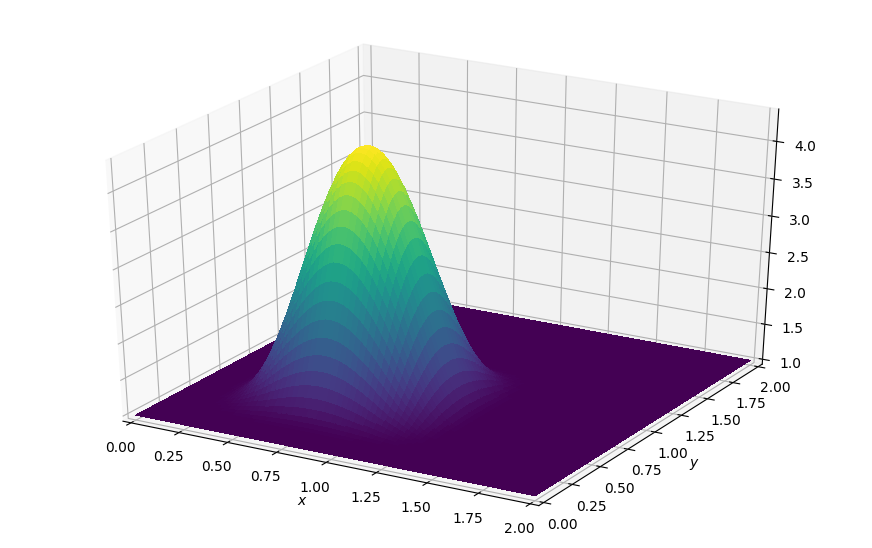

In [9]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

Next, we want to discretize our governing equation so that we can create a functional `Operator` from it. We can start by simply writing out the equation as a symbolic expression, while using the shorthand expressions for derivatives that the `Function` objects provide. This will create a symbolic object of the dicrestized equation.

Can you write out the governing equation using the Devito shorthand expressions? Remember, the governing equation is given as
$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0$$

<button data-toggle="collapse" data-target="#sol3" class='btn btn-primary'>Solution</button>
<div id="sol3" class="collapse">
```
eq = Eq(u.dt + c * u.dxl + c * u.dyl)
eq
```

As we can see, SymPy has kindly resolved our derivatives. Next, we need to rearrange our equation so that the term $u(t+dt, x, y)$ is on the left-hand side, since it represents the next point in time for our state variable $u$. We can use a utility called `solve` to rearrange our equation for us, so that it represents a valid state update for $u$. While sympy provides a version of `solve`, Devito provides its own customized version.

Can you use `solve` to create a valid stencil for our update to $u(t+dt, x, y)$? Hint: `solve` always returns a list of potential solutions, even if there is only one.

Can you then create a `devito.Eq` object to represent a valid state update for the variable $u$?

<button data-toggle="collapse" data-target="#sol4" class='btn btn-primary'>Solution</button>
<div id="sol4" class="collapse">
```
stencil = solve(eq, u.forward)[0]
update = Eq(u.forward, stencil)
update
```

The right-hand side of the update equation should be a stencil of the shape
<img src="figures/stencil_convection.png" style="width: 160px;"/>

Once we have created this update expression, we can create a Devito `Operator`. This `Operator` will basically behave like a Python function that we can call to apply the created stencil over our associated data, as long as we provide all necessary unknowns. In this case we need to provide the number of timesteps to compute via the keyword `time` and the timestep size to use via `dt` (both have been defined above).

In [10]:
op = Operator(update)
op(time=nt+1, dt=dt)

plot_field(u.data[0])

NameError: name 'update' is not defined

Please note that the `Operator` is where all the Devito power is hidden, as the it will automatically generate and compile optimized C stencil code. We can look at this code - although we don't need to execute it.

In [ ]:
print(op.ccode)

## Second derivatives and high-order stencils

For the above example all we had to do was combine some first derivatives. However, lots of common scientific problems require second derivative, most notably any PDE including diffusion. To generate second order derivatives we need to give the `devito.Function` object another piece of information: the desired discretization of the stencils.

First, let's do a simple second derivative in $x$, for which we need to give $u$ at least a `space_order` of `2`. The shorthand for the second derivative is then `u.dx2`. 

In [ ]:
u = TimeFunction(name='u', grid=grid, space_order=2)
u.dx2

We can arbitrarily drive the discretization order up if require higher order stencils. 

In [ ]:
u = TimeFunction(name='u', grid=grid, space_order=4)
u.dx2

To implement diffusion or wave equations, we need to take the Laplacian $\nabla^2 u$, which is simply the second derivative in all space dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`s.

In [ ]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

## Exercise 3: Higher order derivatives

We can re-define our function `u` with a different `space_order` argument to change the discretization order of the created stencil expression. Using the `grid_3d` object, can you derive and expression of the 12th-order Laplacian $\nabla^2 u$? What about the 16th-order stencil for the Laplacian? 

Hint: Devito functions provides a `.laplace` shorthand expression that will work in 2D and 3D.  

<button data-toggle="collapse" data-target="#sol5" class='btn btn-primary'>Solution</button>
<div id="sol5" class="collapse">
```
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace
```

## Exercise 4: Making a wave

In the final exercise of the introduction we will implement a simple wave equation operator to the ones used in seismic imaging. For this we will implement the isotropic wave equation without boundary conditions. The equation defines the propagation of a wave in an isotropic medium and is defined as

$$m \frac{\partial^2 u}{\partial t^2} = \nabla^2 u$$

where $m$ is the square slowness of the wave, defined in terms of the wave speed $c$ as $m = 1 / c^2$. For the purpose of this exercise, we will ignore any source terms and instead use a "warmed-up" wavefield from file.

In the cell below we define the time parameters of our simulation, as well as the spatial dimensions and the shape of our computational grid with a `Grid` object. Using this grid object we can define two functions:
* The wavefield $u(t, x, y)$ which we initialise from the file `wavefield.npy`
* The square slowness $m(x, y)$ which, for now we will keep constant, for $c = 1.5km/s$.

In [ ]:
import numpy as np
from examples.seismic import plot_image

t0, tn, dt = 214., 400, 4.2  # Start, end and timestep size
nt = int(1 + (tn - t0) / dt)  # Number of timesteps

# A 120x120 grid that defines our square domain
grid = Grid(shape=(120, 120), extent=(1800., 1800.))

# Load and plot the initial "warmed-up" wavefield
u = TimeFunction(name='u', grid=grid, space_order=2, time_order=2)
u.data[:] = np.load('wavefield.npy')
plot_image(u.data[0])

# Square slowness for a constant wave speed of 1.5m/s
m = Function(name='m', grid=grid)
m.data[:] = 1. / 1.5**2

To remind ourselves, the governing equation we want to implement is

$$m \frac{\partial^2 u}{\partial t^2} = \nabla^2 u$$

Please have a go and try to implement the operator below. You will need to follow the same strategy to discretize the equation and create a symbolic stencil expression that updates $u(t + dt, x, y)$. Once we apply our `Operator`  for `nt` timesteps we should see that the wave has expanded homogeneously.

In [ ]:
# Reset the wavefield, so that we can run the cell  multiple times
u.data[:] = np.load('wavefield.npy')

# Please implement your wave equation operator here 

In [ ]:
plot_image(u.data[0])

<button data-toggle="collapse" data-target="#sol6" class='btn btn-primary'>Solution</button>
<div id="sol6" class="collapse">
```python
eqn = Eq(m * u.dt2 - u.laplace)
stencil = solve(eqn, u.forward)[0]
update = Eq(u.forward, stencil)
op = Operator(update)

op(t=nt, dt=dt)

```

Now, let's see what happens if we change the square slowness field `m` by increasing the wave speed to $2.5$ in the bottom half of the domain.

In [ ]:
m.data[:, 60:] = 1. / 2.5**2  # Set a new wave speed
plot_image(m.data)

u.data[:] = np.load('wavefield.npy')  # Reset our wave field u
plot_image(u.data[0])

op(t=60, dt=dt)
plot_image(u.data[0])

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the University of Sao Paulo in April 2019.</sup>